# Libraries

In [3]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pds
import seaborn as sns
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from IPython.core.display import Image, display
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from plot_sklearn_dendrogram import plot_sklearn_dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from pandas.plotting import parallel_coordinates
import graphviz 
from sklearn import tree
%matplotlib inline
np.random.seed(10)
random.seed(10)
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing # to scale data
from sklearn.metrics import silhouette_score
from pandas.plotting import parallel_coordinates

# Définition des fonctions

In [ ]:
def compute_stability(k,df,iterations=100):
    silhouette_coef = []
    for i in range(iterations):
        km = KMeans(n_clusters=k, n_init=1, random_state=i) # create a KMeans object
        km.fit(DF_kmeans1)
        labels = km.predict(DF_kmeans1)
        silhouette_coef.append(silhouette_score(DF_kmeans1, labels, metric='euclidean', sample_size=None))
    silhouette_coef = np.asarray(silhouette_coef)
    return(silhouette_coef.std())

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    '''This function allows to draw a dendrogram, with distances annoted inside the dendogram
      Function of Jörn's Blog :
      (https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)  '''
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [3]:
def kmeans_1D(attribute,n):
    """Prend en entrée un nparray et n clusters"""
    km1 = KMeans(n_clusters=n) # create a KMeans object km1.fit(V_Life_expectancy.reshape(-1,1))
    return km1

In [ ]:
def kmeans_SSE(df):
    """Plots SSE evolution for different clusters numbers (from 1 to 15) for a dataframe df."""
    sse = []
    Ks = range(1, 15)
    for k in Ks:
        km = KMeans(n_clusters=k, n_init=20, random_state=k) # create a KMeans object
        km.fit(df)
        #distance.append(np.sqrt(km.inertia_))
        sse.append(km.inertia_)
    plt.plot(Ks,sse)
    plt.xlabel("$k$",fontsize=20)
    plt.ylabel("SSE",fontsize=14)
    return sse

In [ ]:
def plot_dendro_km(df,km):
    """Plots the dendrogram for a specified clustering km and a table df.
    Returns the Agglomerative clustering object."""
    DF_Dendro1 = df.copy(deep=True)
    agc = AgglomerativeClustering(n_clusters=len(km.cluster_centers_), affinity="euclidean", linkage="complete")
    agc.fit(DF_Dendro1)
    plt.title('Hierarchical Clustering Dendrogram')
    plot_sklearn_dendrogram(agc, labels=agc.labels_)
    plt.show()
    return agc

In [ ]:
def plot_kmeans1D(attr,labels):
    """Entree : liste ou nparray"""
   # at  = sorted(attr )
    at = attr
    x_ind = range(0, len(at))
    plt.hist(at);

    plt.show()

In [4]:
# 3D plot using pyplot
def plot_km3d(km,df):
    """km est un objet de Kmeans. df est le dataframe correspondant sur lequel on a fait l'analyse."""
    fig = plt.figure() #opens a figure environment
    ax = Axes3D(fig) #to perform a 3D plot
    x=df.loc[:,'CO2']
    y=df.loc[:,'Population']
    z=df.loc[:,'Life_expectancy']
    ax.scatter(x, y, z,c=km.labels_.astype(np.float)) #plot definition and options 
    ax.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],km.cluster_centers_[:,2],c='r',s=100)
    # We set the colors to be in function of the labels of each cluster, ie each category
    # Cluster centers are in red
    ax.set_xlabel('CO2')
    ax.set_ylabel('Population')
    ax.set_zlabel('Life_expectancy')

In [5]:
def plot_pred_nbclusters(attr):
    """Entree : liste ou nparray"""
   # at  = sorted(attr )
    at =attr
    x_ind = range(0, len(at))
    plt.hist(at )
    plt.show()

In [7]:
def silhouette_kmeans(df):
    """Plots Silhouette coefficient evolution for different values of k (clusters number)."""
    silhouette_coef = []
    Ks = range(2, 30)
    for k in Ks:
        km = KMeans(n_clusters=k, n_init=20, random_state=k) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    plt.plot(Ks,silhouette_coef)
    plt.xlabel("$k$",fontsize=20)
    plt.ylabel("Silhouette Coef.",fontsize=14)

In [8]:
def stability_kmeans(df,ki):
    silhouette_coef = []
    sse = []
    k = ki
    n_init=1
    for i in range(100):
        km = KMeans(n_clusters=k, n_init=n_init, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        sse.append(km.inertia_)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    ax1=plt.subplot(2, 2, 1)
    ax1.hist(sse)
    ax1.set_xlabel("SSE")
    ax2=plt.subplot(2, 2, 2)
    ax2.hist(silhouette_coef)
    ax2.set_xlabel("Silhouette")
    plt.show()

In [8]:
def plot_stability(df):
    stability = []
    Ks = range(2,30)
    for k in Ks:
        stability.append(compute_stability(k,df))
    plt.plot(Ks,stability,"o-")
    plt.xlabel("$k$",fontsize=20)
    plt.ylabel("Instability: std(Silhouette Coef. 100 iterations)")
    plt.show()

In [9]:
def compute_stability(k,df,iterations=100):
    silhouette_coef = []
    for i in range(iterations):
        km = KMeans(n_clusters=k, n_init=1, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    silhouette_coef = np.asarray(silhouette_coef)
    return(silhouette_coef.std())

## Importation des données

In [10]:
df = pds.read_csv('./Data2/Data2.txt', sep="\t") # load a pandas dataframe from csv
df.head()

,Time,Time Code,Country Name,Country Code,Children out of school,CO2 emissions (kt),Non-renewable lectricity production (% of total),Renewable electricity production excluding hydroelectric (% of total),Life expectancy (years),Population,Rural population,Urban population,Surface area (sq. km)
0,2013,YR2013,Afghanistan,AFG,NaN,10014.577,NaN,NaN,62.494,31731688.0,23997724.0,7733964.0,652860.0
1,2013,YR2013,Albania,ALB,10957.0,5064.127,0.00000,0.0,77.702,2895092.0,1291587.0,1603505.0,28750.0
2,2013,YR2013,Algeria,DZA,NaN,134465.223,99.44899,0.0,75.418,38338562.0,11664124.0,26674438.0,2381740.0
3,2013,YR2013,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,55307.0,6997.0,48310.0,200.0
4,2013,YR2013,Andorra,AND,NaN,476.710,NaN,NaN,NaN,80788.0,9261.0,71527.0,470.0


## Description

Les données rassemblent trois grands types de variables : <br>
- Des données environnementales (Ex  : émissions de CO2, production d'énergie verte...)
- Des données de développement (accès à l'éducation, expérance de vie)
- Des données démographiques fondamentales (population totale, rurale, urbaine...)
- Des données géographique (superficie)

## Description des variables

* Colonne n°1 : Time => Année de l'étude
* Colonne n°2 : Time code
* Colonne n°3 : Contry name => pays étudiés
* Colonne n°4 : Country code


* Colonne n°5 : Children out of school, primary <br>
Nombre d'enfants de l'âge de l'école du primaire non scolarisés

<!-- ![Title](Children_Out_of_primary_school.png "Nombre d'enfants  (en million )d'âge du primaire non scolarisés entre 1970 et 2017") -->

* Colonne n°6 : CO2 emissions (kt) <br>
Emissin en CO2 en kilotonnes

![Title](EmissionCO22013.png)
*Rmq : On pourrait considérer cette variable en fonction du nombre total d'habitant par pays?*

* Colonne n°7 : Electricity production from oil, gas and coal sources (% of total) <br>
Pourcentage d'électricité produite via des ressources fossiles par rapport à la production totale d'électricité (données mondiales 2013)

![Title](Electricite_fossile2013.png)


* Colonne n°8 : Electricity production from renewable sources, excluding hydroelectric (% of total)
![Title](Electricite_verte_sauf_hydro_2013.png)

* Colonne n°9 : Life expectancy at birth, total (years) 

* Colonne n°10 : Population, total 
* Colonne n°11 : Rural population 
* Colonne n°12 : Urban population 
* Colonne n°13 : Surface area (sq. km) 

<!--![Title](Poppulation_Urbaine_1960_2017.png)-->

*rmq : on incluera aussi le PIB dans une seconde étude.*

# Data cleaning

## Rename columns

In [11]:
df  = df.rename(index=str, columns={"Children out of school":"School", "CO2 emissions (kt)": "CO2" , "Non-renewable lectricity production (% of total)":"Fossile_electricity", "Renewable electricity production excluding hydroelectric (% of total)" : "Renewable_electricity", "Life expectancy (years)":"Life_expectancy" , "Rural population":"Rural" , "Urban population" : "Urban" ,"Surface area (sq. km)" : "Surface" } )

## Column cleaning

Un prétraitement des données nous a permis de conserver uniquement des attributs pour lesquels on a assez de données. Ainsi, on ne modifie pas les colonnes.

## Row cleaning 

In [12]:
filtered_df = df.dropna(subset=['CO2', 'Population','Life_expectancy']) 
# On enlève toutes les lignes qui contiennent des NA

## Sélection des données à analyser

In [13]:
df_clustering=filtered_df[['CO2','Population','Life_expectancy']]

## Normalisation des données

On analyse les données (pour savoir si on centre-réduit).
Ici, on va forcément centrer les données car les unités sont différentes.

### 1 - Centrage

(-50000000.0, 50000000.0)

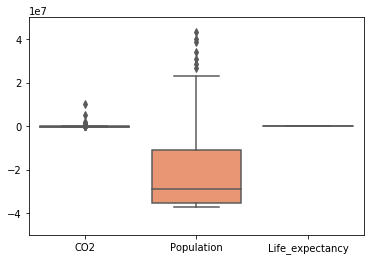

In [14]:
ax=sns.boxplot(data=(df_clustering - df_clustering.mean()), orient="v", palette="Set2")
ax.set_ylim(-0.5e8,0.5e8)

### 2- Réduction

(-2, 2)

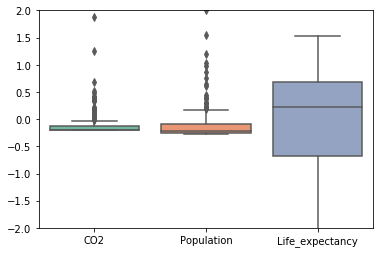

In [15]:
ax=sns.boxplot(data=(( df_clustering - df_clustering.mean() )/df_clustering.std()), orient="v", palette="Set2")
ax.set_ylim(-2,2)

In [16]:
df_clustering_red=(df_clustering - df_clustering.mean())/df_clustering.std()

# Repérage des outliers

## Via DBSCAN

#### Paramétrisation de DBSCAN

On étudie déjà les outliers, avant d'exécuter l'algorithme des Kmeans. Pour cela nous allons utiliser DBSCAN, on considerera que les 'noise points' sont les outliers. Le problème est alors d'estimer les paramètres en entrée de DBSCAN : soit le nombre de points minimum devant se trouver dans un rayon donné, pour considérer un cluster. Pour le déterminer, nous allons tracer le graphique de la distance au quatrième voisin le plus proche en utilisant les données de KNN.

In [17]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(df_clustering_red)
distances, indices = nbrs.kneighbors(df_clustering_red)
distances_to_4 = distances[:,3]
distances_to_4 = sorted(distances_to_4 , reverse = False)

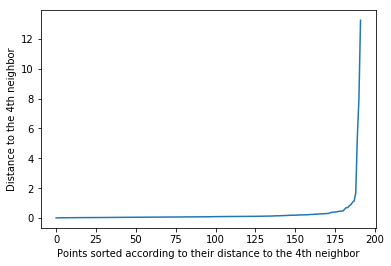

In [18]:
Index = range(0,len(distances_to_4))
plt.plot(Index , distances_to_4)
plt.xlabel('Points sorted according to their distance to the 4th neighbor')
t=plt.ylabel('Distance to the 4th neighbor')

In [19]:
mean_dist_knee = sum(distances_to_4[180:190])/10
mean_dist_knee

1.3527450344278238

Le graphique ci-desssus nous permet d'observer 'un coude'. Autrement dit la distance au quatrième voisin est relativement stable pour les 175 premières valeurs, puis augmente brusquement. 

#### Analyses et résultats de DBSCAN

Nous utiliserons la distance moyenne calculée au niveau du coude (mean_dist_knee ) comme paramètre de DBSCAN.

In [20]:
outliers_det = DBSCAN(min_samples=50,eps=mean_dist_knee).fit(df_clustering_red)
# Number of outliers
sum(outliers_det.labels_ == -1) 

4

D'après nos paramètres, nous repérons 4 outliers.

/Users/mathian/miniconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/mathian/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/mathian/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/mathian/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2

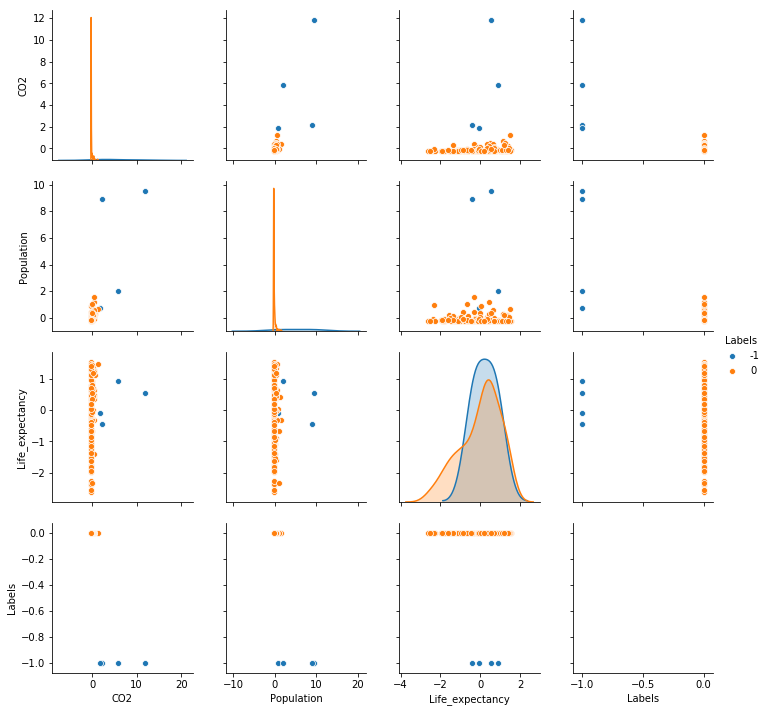

In [21]:
df_clustering_red_lab=df_clustering_red.copy(deep=True)
df_clustering_red_lab['Labels']=outliers_det.labels_
s=sns.pairplot(data=df_clustering_red_lab,hue='Labels') # les labels ne nous servent pas
# Les -1 permettent de repérer les outliers

D'après nos paramètres DBSCAN crée 2 groupes, dont un cluster d'outliers constitué de 4 pays. Dans les pays exclus on retrouve la Chine et l'Inde à cause de leur grande population, mais aussi les Etats-Unis (fort émetteur de CO2) et la Russie.

In [22]:
df_clustering_countries= df_clustering_red_lab.copy(deep=True) # Copy of DF_kmeans1
df_clustering_countries['Country'] = filtered_df['Country Name']
print(df_clustering_countries[df_clustering_countries['Labels'] == -1])

           CO2  Population  Life_expectancy  Labels             Country
41   11.810629    9.510340         0.549868      -1               China
89    2.178481    8.942533        -0.433087      -1               India
161   1.878397    0.765541        -0.083496      -1  Russian Federation
206   5.838196    2.009879         0.912599      -1       United States


## Méthode visuelle 

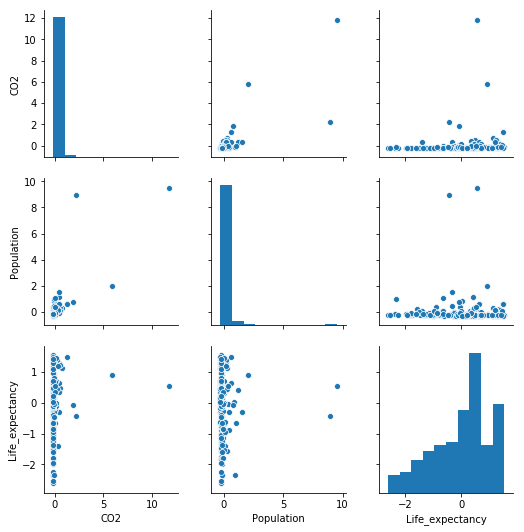

In [23]:
dfScatterPlot = sns.pairplot(data=df_clustering_red)

On remarque 7 points extrêmes pour la population et 5 pour le CO2. Cependant, il est difficile de les discriminer les outliers du reste visuellement.

In [24]:
# Outliers du CO2
df_CO2 = df_clustering_red.sort_values(by =['CO2'] , ascending = False)[5: ][ : ] # Remove Outliers

En traçant à nouveu le pairplot, on voit qu'il reste 6 outliers de population.

In [25]:
df_popCO2 = df_CO2.sort_values(by =['Population'] , ascending = False)[6: ][ : ] # Remove Outliers

Cette méthode a enlevé 11 outliers (soit plus que la méthode de DBSCAN).

# Algorithmes de clustering

## Implémentation de Kmeans

On enlève les outliers trouvés avec DBscan.

In [29]:
df_without_outliers=df_clustering_red[df_clustering_red_lab.Labels != -1]

In [30]:
kmdb = KMeans(n_clusters=3) # create a KMeans object
kmdb.fit(df_without_outliers)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

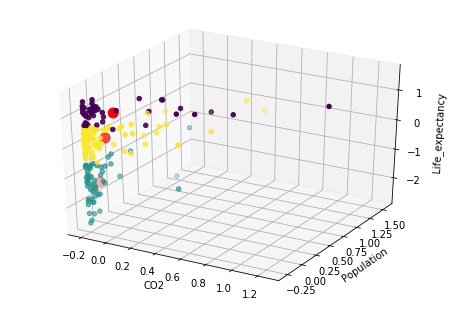

In [31]:
plot_km3d(kmdb,df_without_outliers)

Les 3 clusters trouvés se différencient principalement par l'espérance de vie. On retrouve des pays à différents  niveaux en termes de taille de population et de niveau d'émission de CO2 dans chaque cluster.

Dans ce premier exemple nous avons tenu compte des limitations de la méthodes Kmeans envers les outliers.

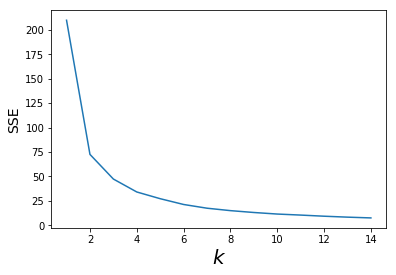

In [27]:
sse=kmeans_SSE(df_without_outliers)

Il est préférable de choisir entre 2 et 4 clusters, c'est ce nombre qui dimineu le plus la SSE et ensuite elle diminue plus lentement.

##### Silhouette

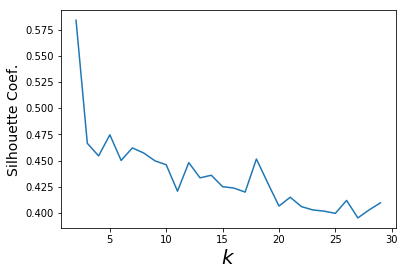

In [28]:
silhouette_kmeans(df_without_outliers)

Ici on ne voit pas de pics "clairs" du coefficient Silhouette. Le max local intéressant peut être celui à 5 clusters car il est dans la plage qui correspond à la forte baisse de SSE.

**Pour l'algorithme de Kmeans, on fixera donc le nombre de clusters à 5.**

In [29]:
km = KMeans(n_clusters=5) # create a KMeans object
km.fit(df_without_outliers)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

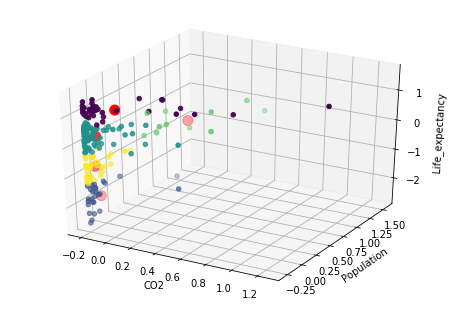

In [30]:
plot_km3d(km,df_without_outliers)

Les 5 clusters trouvés se différencient principalement par l'espérance de vie : on retrouve des points à tous les niveaux d'espérance de vie et de CO2 dans chaque cluster.

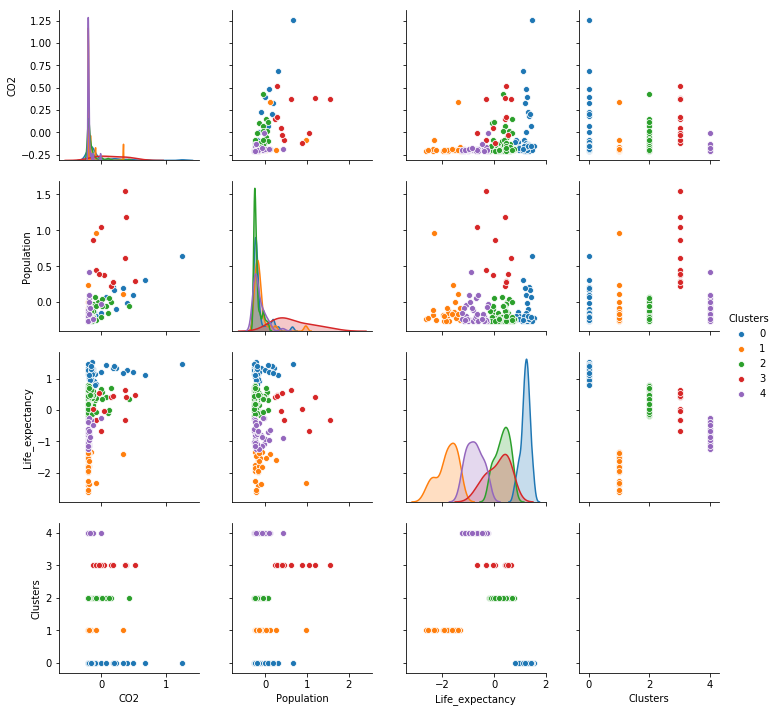

In [31]:
df_kmeans_labels=df_without_outliers.copy()
df_kmeans_labels['Clusters']=km.labels_
s=sns.pairplot(data=df_kmeans_labels,hue='Clusters')

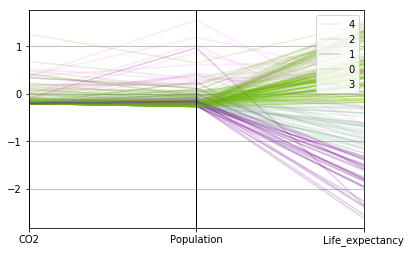

In [32]:
parallel_coordinates(df_kmeans_labels,'Clusters', alpha=0.2)
plt.show()

On remarque que l'espérance de vie est caractéristique d'un groupe. 
Ici, les clusters sont elliptiques et donc les groupes sont difficiles à trouver.
Cependant la population et le CO2 semble corrélés, et nous allons le vérifier dans Kmeans2. ???Comment tu vois ça ?

### Analyse des données du Kmeans

In [33]:
df_kmeans_labels_country = df_kmeans_labels.copy()
df_kmeans_labels_country['Country'] = filtered_df['Country Name']
print(df_kmeans_labels_country['Country'][df_kmeans_labels_country["Clusters"]==1][1:10])
print(len(df_kmeans_labels_country['Country'][df_kmeans_labels_country["Clusters"]==1]))

5                       Angola
20                       Benin
25                    Botswana
30                Burkina Faso
31                     Burundi
34                    Cameroon
37    Central African Republic
38                        Chad
43                     Comoros
Name: Country, dtype: object
54


Comme observé graphiquement le cluster labélisé 1, rassemble 29 les pays très pauvres d'Afrique où l'espérance de vie est faible. 

In [34]:
print(df_kmeans_labels_country['Country'][df_kmeans_labels_country["Clusters"]==0][1:10])
len(df_kmeans_labels_country['Country'][df_kmeans_labels_country["Clusters"]==0])

10            Australia
11              Austria
18              Belgium
21              Bermuda
28    Brunei Darussalam
35               Canada
40                Chile
46           Costa Rica
48              Croatia
Name: Country, dtype: object


49

Le cluster labelisé 1 rassemble 89 pays 'moyennement' développés.

In [35]:
print(df_kmeans_labels_country['Country'][df_kmeans_labels_country["Clusters"]==2][1:10])
len(df_kmeans_labels_country['Country'][df_kmeans_labels_country["Clusters"]==2])

6     Antigua and Barbuda
7               Argentina
8                 Armenia
9                   Aruba
12             Azerbaijan
13           Bahamas, The
14                Bahrain
15             Bangladesh
16               Barbados
Name: Country, dtype: object


85

Le cluster labélisé 2 rassemble les pays riches, mais dans ce classement on retrouve quelques 'incohérences'. En effet dans ce groupe on retrouve les pays de l'Europe Occidentale, Singapour ou encore le Japon mais aussi le Chili ou le Costa Rica, car ces pays ont une grande espérance de vie. On voit ici les limites de ce clustering qui n'explique qu'une variable, l'espérance de vie. Il serait judicieux de choisir d'augmenter le nombre de cluster pour prendre en compte les autres variables, ou bien d'utiliser un clustering hiérarchique pour nous orienter dans l'initialisation des centroïdes. 

## Clustering hiérarchique

L'objectif de cette section est d'utiliser les clusters données par la méthode de clustering hiérarchique pour initialiser les centroïdes de l'algorithme des Kmeans.

### Clustering hiérarchique avec la méthode MAX

La méthode 'Max' permet de définir les clusters grâce la distance séparant les point les moins similaires entre deux clusters. Cette méthode permet de définier des clusters très séparés, néanmoins elle est sensible aux outiliers.

Le clustering agglomératif met en évidence 3 points isolés. Ce sont certainement 3 des outliers déterminés à la partie 1.

### Clustering hiérarchique sur données sans outliers

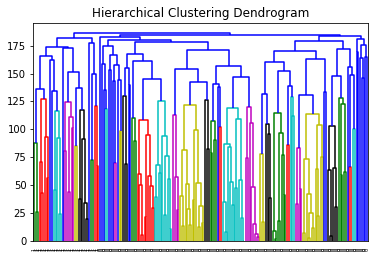

In [38]:
acwo = AgglomerativeClustering(affinity="euclidean", linkage="complete")
acwo.fit(df_without_outliers)
plt.title('Hierarchical Clustering Dendrogram')
plot_sklearn_dendrogram(acwo,labels=acwo.labels_)
plt.show()

Ce dendrogramme est difficilement analysable

### Construction de la matrice de proximité

In [37]:
Z = linkage(df_without_outliers, 'complete')
# Z is a linkage matrix where distances are calculated owing complete method which is also named max

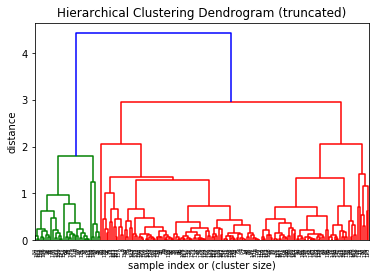

In [38]:
dn = dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

Ce dendrogrmma est plus facile à analyser, il nous permet d'une part de mettre en évidence deux clusters (rouge et vert), mais aussi de mettre en évidece une distance (2.2), pour la quelle on distingue correctement trois groupes.  

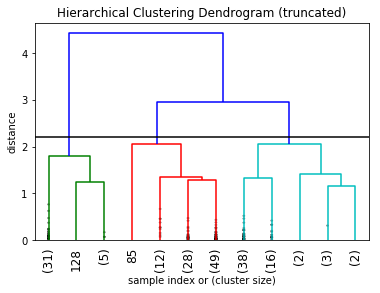

In [39]:
max_d = 2.2
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

**Récupérons à présent les clusters formés**

In [40]:
clusters = fcluster(Z, max_d, criterion='distance')
df_without_outliers_dendro_cluster = df_without_outliers.copy()
df_without_outliers_dendro_cluster['clusters'] = clusters


**Analyse des résultats du clustering hiérarchique**

In [41]:
df_without_outliers_dendro_cluster['country']= filtered_df['Country Name']

Text(0.5,0,'Life_expectancy')

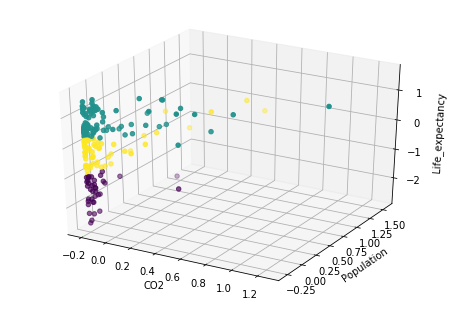

In [42]:
    fig = plt.figure() #opens a figure environment
    ax = Axes3D(fig) #to perform a 3D plot
    x=df_without_outliers_dendro_cluster.loc[:,'CO2']
    y=df_without_outliers_dendro_cluster.loc[:,'Population']
    z=df_without_outliers_dendro_cluster.loc[:,'Life_expectancy']
    ax.scatter(x, y, z,c=df_without_outliers_dendro_cluster.loc[:,'clusters'].astype(np.float)) #plot definition and options 
   
    # We set the colors to be in function of the labels of each cluster, ie each category
    # Cluster centers are in red
    ax.set_xlabel('CO2')
    ax.set_ylabel('Population')
    ax.set_zlabel('Life_expectancy')

On obtient des résultats très similaires que ceux obtenus grâce au premier Kmeans.

**Calculons les moyennes des trois variables pour déterminer les centroïdes initiaux de Kmeans**

In [43]:
means = df_without_outliers_dendro_cluster.groupby('clusters').mean()
type(means)
Means =np.array(means)

/Users/mathian/miniconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:968: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


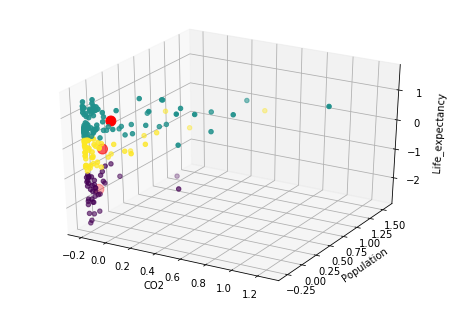

In [44]:
kmdendro_max = KMeans(n_clusters=3, init = Means) # create a KMeans object
kmdendro_max.fit(df_without_outliers)
plot_km3d(kmdendro_max,df_without_outliers)

Étant donné la remarque précédente il n'est pas étonnant que ce kmeans initialisé grâce aux classes données par le dendrogramme soit quasi identique au premier.

## DBSCAN

Au vu des différences de densité entre nos points, on peut penser que DBSCAN ne donnera pas de bons résultats.
La diffilcuté sera de déterminer les paramètres eps et min_samples...

On choisit eps inférieur à mean_dist_knee=1.3 et min_samples =2.

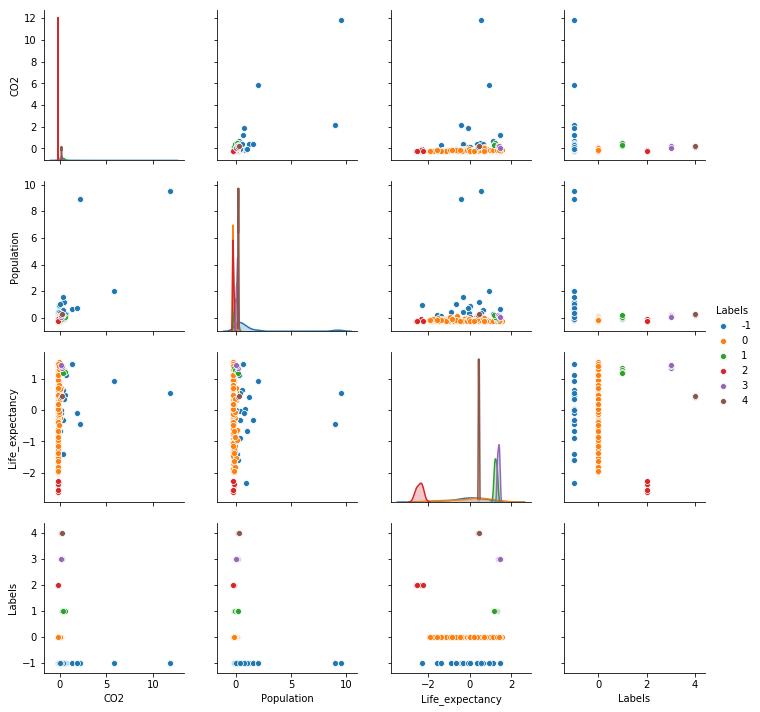

In [45]:
db=DBSCAN(min_samples=10,eps=.21).fit(df_without_outliers)
df_clustering_wo_lab=df_without_outliers.copy(deep=True)
df_clustering_wo_lab['Labels']=db.labels_
s=sns.pairplot(data=df_clustering_wo_lab,hue='Labels') # les labels ne nous servent pas

L'algorithe trouve 3 clusters et beaucoup de points sont considérés comme "noise points".
On remarque que comme dans le cas de Kmeans, l'espérance de vie est un facteur discriminant.

### Relance de Kmeans avec un autre nb de clusters

In [46]:
kmdb4 = KMeans(n_clusters=4) # create a KMeans object
kmdb4.fit(df_without_outliers)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

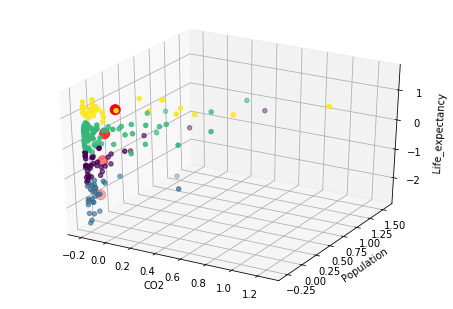

In [47]:
plot_km3d(kmdb4,df_without_outliers)


Qualitativement : pas de différence importante par rapport à 3 clusters.

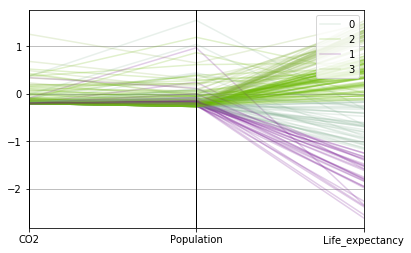

In [48]:


df_kmeans_labels['Clusters']=kmdb4.labels_
parallel_coordinates(df_kmeans_labels,'Clusters', alpha=0.2)
plt.show()

On remarque que l'espérance de vie est caractéristique d'un groupe. 
Ici, les clusters sont elliptiques et donc les groupes sont difficiles à trouver.
Cependant la population et le CO2 semble corrélés, et nous allons le vérifier dans Kmeans2.

## Analyse

### Qualité du clustering

#### SSE

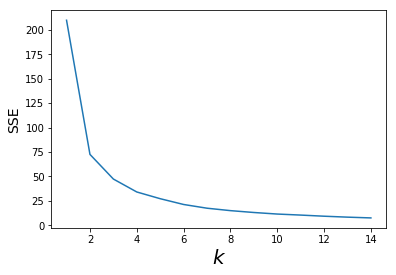

In [49]:
sse=kmeans_SSE(df_without_outliers)

Il est préférable de choisir entre 2 et 4 clusters comme on l'a fait, c'est ce nombre qui dimineu le plus la SSE et ensuite elle diminue plus lentement.

#### Silhouette

In [44]:
skm=silhouette_score(df_without_outliers, km.labels_, metric='euclidean', sample_size=None)
sac=silhouette_score(df_without_outliers, ac.labels_, metric='euclidean', sample_size=None)
sdb=silhouette_score(df_without_outliers, db.labels_, metric='euclidean', sample_size=None)
print("Silhouette score for kmeans : {0}, for agglomerative clustering = {1}, for DBSCAN : {2}".format(skm,sac,sdb))

Silhouette score for kmeans : 0.475845984426, for agglomerative clustering = 0.443756877887, for DBSCAN : 0.338384142828


Le clustering qui sépare le mieux les données est Kmeans.

On pourrait ensuite comparer les valeurs de coefficient silhouette obtenus avec nos clusterings à des clusterings sur données aléatoires, et faire une étude statistique pour voir si la mesure est significative d'un "bon" clustering.

## Analyse des clusterings

### Stabilité

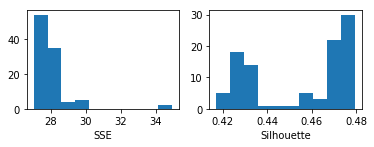

In [45]:
stability_kmeans(df_without_outliers,5)

Pour 5 clusters, l'algorithme de Kmeans est plutôt instable puisque les valeurs de SSE et de coefficient silhouette ne sont pas mes mêmes si on répète plusieurs fois le clustering.

#### Stabilité avec différents nombres de clusters

In [52]:
DF_kmeans1 = df_kmeans_labels.copy()
stability = []
Ks = range(2,30)
for k in Ks:
    stability.append(compute_stability(k,DF_kmeans1))

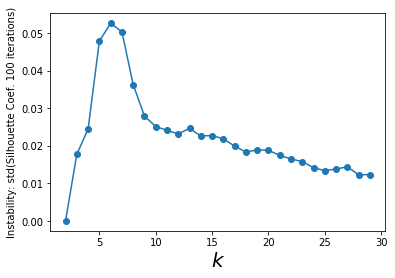

In [53]:
plot_stability(df_without_outliers)

Kmeans est particulièrement instable autour des 5 clusters choisis... 

# Kmeans 2


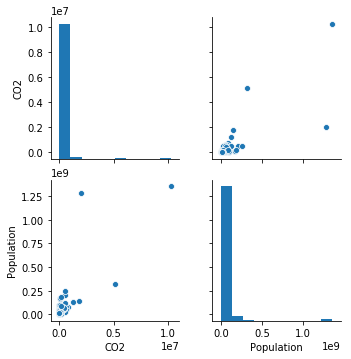

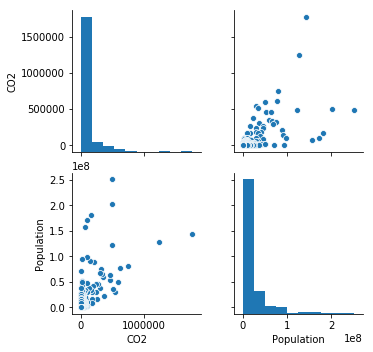

In [47]:
DF_kmeans2 = filtered_df[['CO2'  , 'Population' ]] 
dfScatterPlot = sns.pairplot(data=DF_kmeans2)

DF_kmeans2 = DF_kmeans2.sort_values(by =['CO2'] , ascending = False)[3: ][ : ] # Remove Outliers
dfScatterPlot = sns.pairplot(data=DF_kmeans2)

In [48]:
km2 = KMeans(n_clusters=3) # create a KMeans object
km2.fit(DF_kmeans2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

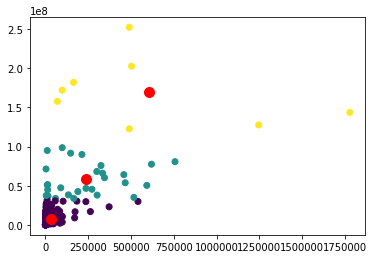

In [49]:
plt.scatter(data=DF_kmeans2, x="CO2", y="Population" , c=km2.labels_.astype(np.float))
plt.scatter(km2.cluster_centers_[:,0],km2.cluster_centers_[:,1],c='red',s=100)


On observe d'après ce graphique les limites du Kmeans 

### Vision d'ensemble des données

## Contingence DBSCAN et KMEAN

In [50]:
df_GDP = pds.read_csv('./Data_GDP/Data_GDP.txt', sep="\t") # load a pandas dataframe from csv

df_without_outliers.index

Index([u'0', u'1', u'2', u'5', u'6', u'7', u'8', u'9', u'10', u'11',
       ...
       u'205', u'207', u'208', u'209', u'210', u'211', u'213', u'214', u'215',
       u'216'],
      dtype='object', length=188)

Nous utiserons la GDP comme classe étiquette

# Arbre de décision 

## Enveloppe des cluster

In [52]:
Tree_enveloppe = df_without_outliers.copy(deep=True)
Tree_enveloppe['Labels']=kmdb.labels_
classes=Tree_enveloppe['Labels']
features=Tree_enveloppe.drop('Labels',axis=1)

In [53]:
model  = DecisionTreeClassifier(criterion = 'entropy') # part aleatoire si deux split possibles 
                                                    # surtout si deux index sous equivalent gini entropy ...
clf = model.fit(features , classes)
sortedLabelList = ['0', '1', '2']

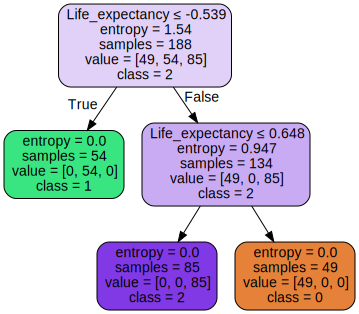

In [54]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features.columns,  
                         class_names=(sortedLabelList),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

##  Arbre de décision sur l'espérance de vie

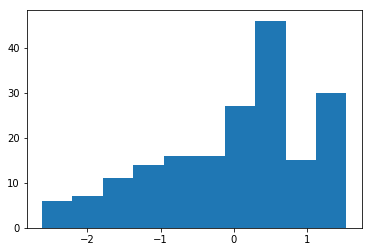

In [81]:
V_Life_expectancy  = np.array(df_without_outliers['Life_expectancy'])
plot_pred_nbclusters(V_Life_expectancy)
KM_LE = kmeans_1D(V_Life_expectancy , 3)


#plot_kmeans1D(V_Life_expectancy,KM_LE.labels_)

##  Arbre de décision sur le CO2

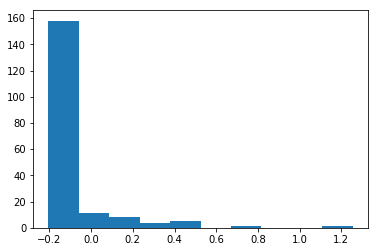

In [59]:
V_CO2  = np.array(df_without_outliers['CO2'])
plot_pred_nbclusters(V_CO2)
KM_CO2 = kmeans_1D(V_CO2 , 2)

#plot_kmeans1D(V_CO2,KM_CO2.labels_)

# Arbre de décision avec classe en fonction des sorties de Kmeans LE

In [60]:
Tree_LE = df_without_outliers.copy(deep=True)
Tree_LE['Labels']=KM_LE.labels_
classes=Tree_LE['Labels']
features=Tree_LE.drop('Labels',axis=1)
Tree_LE =Tree_LE.drop('Life_expectancy',axis=1)

model  = DecisionTreeClassifier(criterion = 'entropy') # part aleatoire si deux split possibles 
                                                    # surtout si deux index sous equivalent gini entropy ...
clf = model.fit(features , classes)
sortedLabelList = ['0', '1', '2']

AttributeError: 'KMeans' object has no attribute 'labels_'

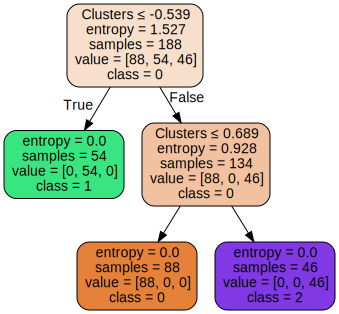

In [61]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=Tree_LE.columns,  
                         class_names=sortedLabelList,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 